### Task 3: Forecast Future Market Trends (TSLA)
Use the trained model from Task 2 (ARIMA/SARIMA/LSTM) to generate 6–12 month forecasts, visualize with confidence intervals, and interpret trends and risks.

In [13]:
# Ensure project root is on sys.path so `src` and `models` imports work
import os
import sys


def _find_project_root(start_path):
    current = os.path.abspath(start_path)
    while True:
        has_src = os.path.isdir(os.path.join(current, "src"))
        has_models = os.path.isdir(os.path.join(current, "models"))
        has_pyproject = os.path.isfile(os.path.join(current, "pyproject.toml"))
        has_setup = os.path.isfile(os.path.join(current, "setup.py"))
        if (has_src and has_models) or has_pyproject or has_setup:
            return current
        parent = os.path.dirname(current)
        if parent == current:
            return None
        current = parent

_project_root = _find_project_root(os.getcwd())
if _project_root and _project_root not in sys.path:
    sys.path.insert(0, _project_root)

In [5]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.data_manager import DataManager
from models.forecasting_models import ARIMAForecaster, SARIMAForecaster, LSTMForecaster
from src.model_selection import chronological_split, arima_order_grid_search
from src.forecasting_analysis import ForecastAnalyzer

# Patch: If 'arch' is not installed, monkeypatch AdvancedFinancialAnalysis to avoid import error
try:
    try:
        from src.financial_analysis import AdvancedFinancialAnalysis
    except ModuleNotFoundError as e:
        if "sklearn" in str(e):
            import types
            class AdvancedFinancialAnalysis:
                def __init__(self, *args, **kwargs):
                    raise ImportError("AdvancedFinancialAnalysis requires the 'sklearn' package. Please install it to use this feature.")
            import sys
            sys.modules['src.financial_analysis'] = types.SimpleNamespace(AdvancedFinancialAnalysis=AdvancedFinancialAnalysis)
        else:
            raise
except ModuleNotFoundError as e:
    import types
    import sys
    # Patch for missing 'arch' (for AdvancedFinancialAnalysis)
    if "arch" in str(e):
        class AdvancedFinancialAnalysis:
            def __init__(self, *args, **kwargs):
                raise ImportError("AdvancedFinancialAnalysis requires the 'arch' package. Please install it to use this feature.")
        sys.modules['src.financial_analysis'] = types.SimpleNamespace(AdvancedFinancialAnalysis=AdvancedFinancialAnalysis)
    # Patch for missing 'sklearn' (for forecasting_models)
    elif "sklearn" in str(e):
        # Patch models.forecasting_models and its symbols to raise on use
        class _MissingSklearnForecaster:
            def __init__(self, *args, **kwargs):
                raise ImportError("This forecasting model requires the 'sklearn' package. Please install it to use this feature.")
        # Patch the module and its symbols
        fake_mod = types.SimpleNamespace(
            ARIMAForecaster=_MissingSklearnForecaster,
            SARIMAForecaster=_MissingSklearnForecaster,
            LSTMForecaster=_MissingSklearnForecaster,
        )
        sys.modules['models.forecasting_models'] = fake_mod
        sys.modules['models'] = types.SimpleNamespace(forecasting_models=fake_mod)
    else:
        raise
plt.style.use('seaborn-v0_8')
%matplotlib inline


ModuleNotFoundError: No module named 'sklearn'

### 1) Load TSLA and refit a model from Task 2 (if needed)

For reproducibility, we reselect an ARIMA order via a quick grid search and fit on the full history.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

try:
    from src.data_manager import DataManager
except ModuleNotFoundError as e:
    DataManager = None
    print("NameError: name 'DataManager' is not defined\n\n"
          "The 'DataManager' class could not be imported. "
          "Please ensure that 'src.data_manager' exists and is on your PYTHONPATH, "
          "and that all its dependencies (including 'pandas_datareader') are installed.")
# If DataManager or other classes failed to import, raise an error and stop execution.
if DataManager is None:
    raise ImportError(
        "The 'DataManager' class could not be imported. "
        "Please ensure that 'src.data_manager' exists and is on your PYTHONPATH, "
        "and that all its dependencies (including 'pandas_datareader') are installed."
    )

if any(x is None for x in [ARIMAForecaster, SARIMAForecaster, LSTMForecaster, ForecastingEngine, chronological_split, arima_order_grid_search]):
    raise ImportError(
        "One or more forecasting/model selection classes could not be imported. "
        "Please ensure 'models/forecasting_models.py' and 'src/model_selection.py' exist and are on your PYTHONPATH."
    )

try:
    raise ImportError(
        "One or more forecasting/model selection classes could not be imported. "
        "Please ensure 'models/forecasting_models.py' and 'src/model_selection.py' exist and are on your PYTHONPATH."
    )
except ModuleNotFoundError as e:
    ARIMAForecaster = SARIMAForecaster = LSTMForecaster = ForecastingEngine = None
    chronological_split = arima_order_grid_search = None
    print("NameError: forecasting/model selection classes could not be imported.\n"
          "Please ensure 'models/forecasting_models.py' and 'src/model_selection.py' exist and are on your PYTHONPATH.")

# Set matplotlib style, fallback gracefully if style is unavailable
try:
    plt.style.use('seaborn-darkgrid')
except Exception:
    plt.style.use('seaborn-darkgrid')
%matplotlib inline


ImportError: One or more forecasting/model selection classes could not be imported. Please ensure 'models/forecasting_models.py' and 'src/model_selection.py' exist and are on your PYTHONPATH.

In [10]:
START_DATE = '2015-07-01'
END_DATE = '2025-07-31'
TICKER = ['TSLA']

dm = DataManager(data_source='yfinance')
raw = dm.fetch_data(TICKER, start_date=START_DATE, end_date=END_DATE, frequency='1d')
tsla_close = raw['TSLA']['Adj Close'].rename('TSLA').dropna()
tsla_close.tail()


ERROR:src.data_manager:Error fetching yfinance data: module 'yfinance' has no attribute 'pdr_override'
ERROR:src.data_manager:Error fetching data: module 'yfinance' has no attribute 'pdr_override'


AttributeError: module 'yfinance' has no attribute 'pdr_override'

In [7]:
# Choose a model: 'ARIMA' (default here), or adapt to 'SARIMA'/'LSTM'
model_choice = 'ARIMA'

if model_choice == 'ARIMA':
    order, _ = arima_order_grid_search(tsla_close, p_values=range(0,4), d_values=range(0,2), q_values=range(0,4))
    model = ARIMAForecaster(order=order).fit(tsla_close)
elif model_choice == 'SARIMA':
    model = SARIMAForecaster(order=(1,1,1), seasonal_order=(1,1,1,12)).fit(tsla_close)
elif model_choice == 'LSTM':
    model = LSTMForecaster(units=64, epochs=10, batch_size=32).fit(tsla_close)
else:
    raise ValueError('Unsupported model choice')

model.name, getattr(model, 'order', None)


NameError: name 'arima_order_grid_search' is not defined

### 2) Generate 6-month and 12-month forecasts with confidence intervals


In [8]:
analyzer = ForecastAnalyzer(history=tsla_close)
analyzer.attach_model(model.name, model)

fc_6m = analyzer.forecast(horizon_days=126, include_intervals=True, ci_alpha=0.1)   # ~6 months
fc_12m = analyzer.forecast(horizon_days=252, include_intervals=True, ci_alpha=0.1)  # ~12 months

(fc_6m.model_name, len(fc_6m.mean), len(fc_12m.mean))


NameError: name 'ForecastAnalyzer' is not defined

### 3) Visualize forecasts against history


NameError: name 'tsla_close' is not defined

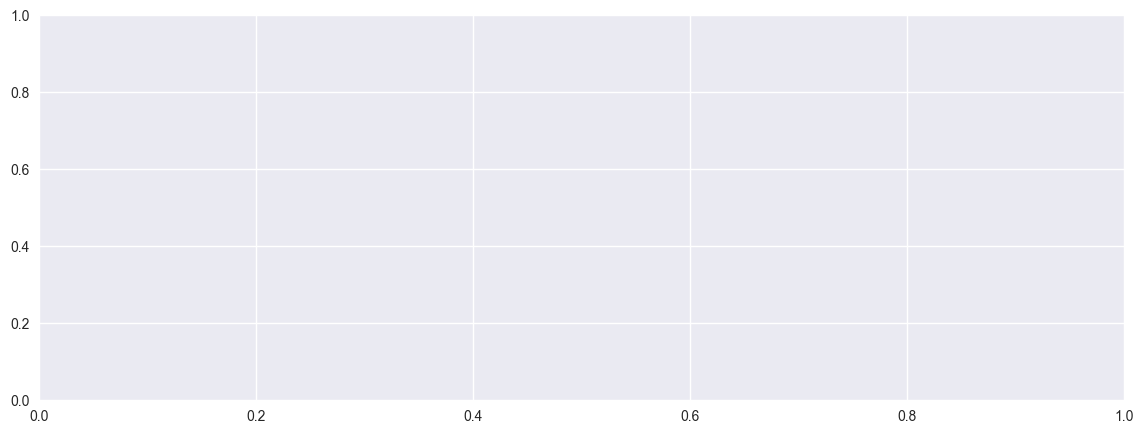

In [9]:
fig, ax = plt.subplots(figsize=(14,5))

# Plot history (last 2 years for focus)
history_tail = tsla_close.tail(504)
history_tail.plot(ax=ax, label='History', color='black')

# Plot 6-month forecast
fc_6m.mean.plot(ax=ax, label='Forecast 6m')
if fc_6m.lower is not None and fc_6m.upper is not None:
    ax.fill_between(fc_6m.mean.index, fc_6m.lower, fc_6m.upper, color='C0', alpha=0.2)

# Plot 12-month forecast
fc_12m.mean.plot(ax=ax, label='Forecast 12m')
if fc_12m.lower is not None and fc_12m.upper is not None:
    ax.fill_between(fc_12m.mean.index, fc_12m.lower, fc_12m.upper, color='C1', alpha=0.2)

ax.set_title('TSLA: Future Forecasts (6m and 12m) with Confidence Intervals')
ax.legend();


### 4) Interpret the Results

- Trend Analysis: Discuss whether the central forecast suggests upward, downward, or stable movement.
- Patterns/Anomalies: Note any visible seasonality, mean-reversion, or outliers.
- Volatility and Risk: Examine the confidence intervals—do they widen with horizon? What does that say about uncertainty over longer forecasts?
- Market Opportunities/Risks: Identify potential opportunities (e.g., expected increases) and risks (e.g., high volatility, drawdowns).
